In [41]:
import nengo
import multiprocessing
import numpy as np
from itertools import product
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from hashids import Hashids
import run_motif_search
reload(run_motif_search)
from run_motif_search import *
import os
import scipy
from tqdm import tqdm

In [2]:
def load_file(fn):
    pass


(array([[0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0]]), array([[1, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 0]]))


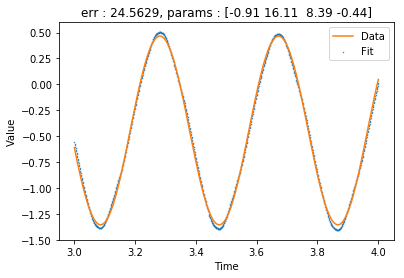

In [3]:
# Initial check
path = './data_s0_f'
# Generator over filenames so they're not loaded into memory
_fr,_dirname,files = os.walk(path).next()
files = ['oRcLcZcqfYfQcWcqcDcofqcXcOcncxfZcgfLc7cocrcpcVc8cRc1cWfjcQc7c6cE.pkl']
for i,fn in enumerate(files):
    with open(os.path.join(path,fn), 'rb') as fp:
        ret = pickle.load(fp)
    print(ret['_metadata'])
    fig, ax = plt.subplots()
    
    tslc = slice(3000,4000)
    ax.scatter(ret['time'][tslc], ret['motor_values'][tslc], s=0.2)
    params, cov,err,yhat = fit_curve(ret, tslc)
    ax.title.set_text("err : {}, params : {}".format(np.round(err,4),np.round(params,2)))
#     params[0] = 0.001
    ax.plot(ret['time'][tslc], yhat, color='tab:orange')
    ax.legend(['Data','Fit'])
    ax.set_ylabel('Value')
    ax.set_xlabel('Time')
    
    if i > 0:
        break

        
#     with ) as fp:



In [4]:
datafiles = os.listdir(path)

In [5]:
df = pd.DataFrame(columns=['err','cov','a','b','c','e'])

In [6]:

def async_fit(fn):
    tslc = slice(3000,4000)
    with open(os.path.join(path,fn), 'rb') as fp:
        ret = pickle.load(fp)
    del fp
    return fit_curve(ret, tslc), fn
pool=multiprocessing.Pool(processes=4)

for ret,fn in tqdm(pool.imap_unordered(async_fit,datafiles,chunksize=50), total=len(datafiles)):
    
        (params, cov, err, yhat) = ret
        del yhat
        df.loc[fn, 'err'] = err
        df.loc[fn, 'cov'] = [cov]
        df.loc[fn, ['a','b','c','e']] = params


  0%|          | 198/107848 [00:08<32:00, 56.05it/s]  /home/raph/.local/lib/python2.7/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
  4%|▍         | 4269/107848 [03:02<1:54:46, 15.04it/s]/home/raph/.local/lib/python2.7/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
  5%|▍         | 5183/107848 [03:41<29:15, 58.48it/s]  /home/raph/.local/lib/python2.7/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
  5%|▌         | 5785/107848 [04:08<1:00:38, 28.05it/s]/home/raph/.local/lib/python2.7/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
100%|██████████| 107848/107848 [1:57:11<00:00, 15.34it/s] 


In [18]:
pool.terminate()
pool.close()

In [33]:
df = df.dropna()
df.to_pickle('sin_fit_results_df2_s0_f.pkl')

In [25]:

len(df)

102520

In [26]:
unique_idx = df.duplicated(subset=['a','b','c','e','err'])
unique_idx.value_counts()

True     96879
False     5641
dtype: int64

In [27]:
df[~unique_idx].to_pickle('sin_fit_results_df2_s0_f_u.pkl')

In [28]:
grouped = df.groupby(['a','b','c','e','err'])


In [51]:
def pick_isomorphisms(fns):
    
    uniques = {}
    for fn in fns:
        with open(os.path.join(path,fn), 'rb') as fp:
            ret = pickle.load(fp)
        del fp
        mm, lr = ret['_metadata']
        adj = construct_graph(mm,lr)
        G = nx.from_numpy_matrix(adj, create_using=nx.DiGraph)
        not_unique = False
        for u in uniques.values():
            not_unique = nx.algorithms.isomorphism.is_isomorphic(G,u)
            if not not_unique:
                break
        if not not_unique:
            uniques[fn] = G
    return uniques.keys()
pool=multiprocessing.Pool(processes=4)
uniques = []
pick_isomorphisms(grouped.groups.values()[0])
for ret in tqdm(pool.imap_unordered(pick_isomorphisms,grouped.groups.values(),chunksize=50), total=len(grouped.groups)):
    uniques.extend(ret)
        

100%|██████████| 5641/5641 [1:10:07<00:00,  1.34it/s]


In [52]:
print(len(uniques))
np.save('uniques2_s0_f_u', uniques)

77420
